# Color Change Detection

## Read the csv file

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import threading
import time

df = pd.read_csv("streaming.csv")
df.head()

,Seconds,Alpha,Red,Green,Blue
0,1,-26,-155,-285,1
1,2,-4,0,-48,-104
2,3,-15,-60,-165,-345
3,4,23,115,299,161
4,5,-5,-38,2,-28


## For each color, calculate the R-squared with a rolling window of 500 seconds

In [2]:
#Define R-squared

def getRSquared(num):
    output = []
    for row_index in range(501, df.shape[0]+1):
        df_slice = df[(row_index-500):(row_index+1)]
        model = sm.OLS(df_slice.iloc[:,(num+2)], df_slice.iloc[:,1])
        reg = model.fit()
        output.append(reg.rsquared)
    return(output)

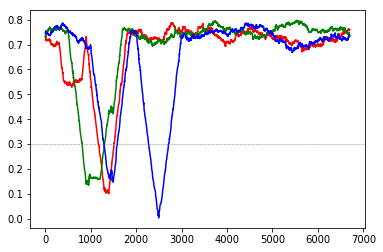

Calculation took 15.283154249191284 seconds


In [3]:
#Calculate and plot R-squared of 3 colors using single thread

SSRP_single = [None]*3
start = time.time()

SSRP_single[0] = getRSquared(0)
SSRP_single[1] = getRSquared(1)
SSRP_single[2] = getRSquared(2)

plt.plot(SSRP_single[0], color='red')
plt.plot(SSRP_single[1], color='green')
plt.plot(SSRP_single[2], color='blue')
plt.axhline(y=0.3, linewidth = 0.5, color='grey', linestyle='--')
plt.show()

process_time = time.time() - start
process_time
print("Calculation took {} seconds".format(process_time))

## Find the approximate seconds you encounter problems of correlation between the colors and the alpha

In [4]:
#'Red'
red_array = np.array(SSRP_single[0])
red_array_bad_0_index = np.where(red_array == red_array[red_array < 0.3][0])
red_array_bad_1_index = np.where(red_array == red_array[red_array < 0.3][-1])
#'Green'
green_array = np.array(SSRP_single[1])
green_array_bad_0_index = np.where(green_array == green_array[green_array < 0.3][0])
green_array_bad_1_index = np.where(green_array == green_array[green_array < 0.3][-1])
#'Blue'
blue_array1 = np.array(SSRP_single[2])[0:2000]
blue_array2 = np.array(SSRP_single[2])[2000:]
blue_array1_bad_0_index = np.where(blue_array1 == blue_array1[blue_array1 < 0.3][0])
blue_array1_bad_1_index = np.where(blue_array1 == blue_array1[blue_array1 < 0.3][-1])
blue_array2_bad_0_index = np.where(blue_array2 == blue_array2[blue_array2 < 0.3][0])
blue_array2_bad_1_index = np.where(blue_array2 == blue_array2[blue_array2 < 0.3][-1])

print('Problems of correlation between red and the alpha is from {}s to {}s'.
      format(int(red_array_bad_0_index[0]), int(red_array_bad_1_index[0])))
print('Problems of correlation between green and the alpha is from {}s to {}s'.
      format(int(green_array_bad_0_index[0]), int(green_array_bad_1_index[0])))
print('Problems of correlation between blue and the alpha is from {}s to {}s and from {}s to {}s'.
      format(int(blue_array1_bad_0_index[0]), int(blue_array1_bad_1_index[0]), 
             int(blue_array2_bad_0_index[0]+2000), int(blue_array2_bad_1_index[0]+2000)))

Problems of correlation between red and the alpha is from 1169s to 1510s
Problems of correlation between green and the alpha is from 811s to 1301s
Problems of correlation between blue and the alpha is from 1289s to 1585s and from 2274s to 2708s


## For each color, calculate the R-squared with a rolling window of 500 seconds using multithreading

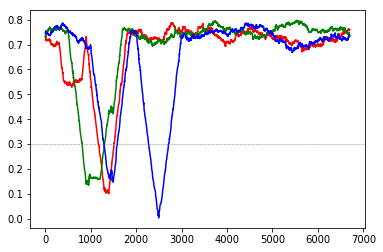

Multithreading took 27.74584674835205 seconds


In [5]:
#Calculate and plot R-squared of 3 colors using multithreading

totalThreads=3
SSRP_multi = [None]*3
    
def ParallelRegression_RS(threadnum):
    SSRP_multi[threadnum] = getRSquared(threadnum)

threads=[]
start = time.time()
for threadnum in range(totalThreads):
    t = threading.Thread(target=ParallelRegression_RS,args=[threadnum])
    threads.append(t)
    t.start()
for threadnum in range(totalThreads):
    threads[threadnum].join()
    
plt.plot(SSRP_multi[0], color='Red')
plt.plot(SSRP_multi[1], color='Green')
plt.plot(SSRP_multi[2], color='Blue')
plt.axhline(y=0.3, linewidth = 0.5, color='grey', linestyle='--')
plt.show()

process_time = time.time() - start
process_time
print("Multithreading took {} seconds".format(process_time))

R-squareds generated by single thread and by multithreading are the same for three colors

In [6]:
for i in range(3):
    print(SSRP_single[i] == SSRP_multi[i])

True
True
True


## Using other methods instead of R squared

### We will have the same results (the time windows of color change) using other methods including the upper bound of the slope's confidence interval and the slope's t score

1. Use upper bound of the slope's confidence interval to show the correlation between alpha and colors: results are the same as generated by R squared

In [7]:
def getCI_upper(num):
    output = []
    for row_index in range(501, df.shape[0]+1):
        df_slice = df[(row_index-500):(row_index+1)]
        model = sm.OLS(df_slice.iloc[:,(num+2)], df_slice.iloc[:,1])
        reg = model.fit()
        CI_upper = reg.conf_int(alpha=0.01, cols=None)[1]
        output.append(CI_upper)
    return(output)

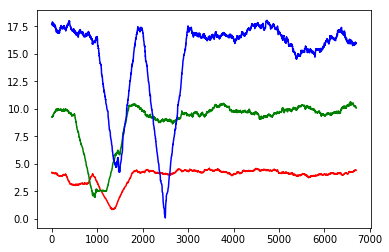

Calculation took 27.692989349365234 seconds


In [8]:
#Single thread version

ALT_single = [None]*3
start = time.time()

#ALT_single[0] = getTScore(0)
#ALT_single[1] = getTScore(1)
#ALT_single[2] = getTScore(2)

ALT_single[0] = getCI_upper(0)
ALT_single[1] = getCI_upper(1)
ALT_single[2] = getCI_upper(2)

plt.plot(ALT_single[0], color='red')
plt.plot(ALT_single[1], color='green')
plt.plot(ALT_single[2], color='blue')
plt.show()

process_time = time.time() - start
process_time
print("Calculation took {} seconds".format(process_time))

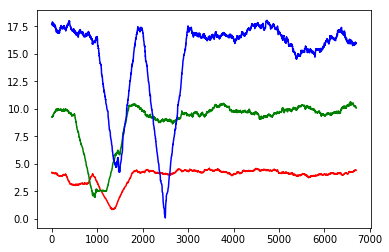

Multithreading took 50.24571633338928 seconds


In [9]:
#Multithreading

totalThreads=3
ALT_multi = [None]*3
    
def ParallelRegression_TS(threadnum):
#    ALT_multi[threadnum] = getTScore(threadnum)
    ALT_multi[threadnum] = getCI_upper(threadnum)    

threads=[]
start = time.time()
for threadnum in range(totalThreads):
    t = threading.Thread(target=ParallelRegression_TS,args=[threadnum])
    threads.append(t)
    t.start()
for threadnum in range(totalThreads):
    threads[threadnum].join()
    
plt.plot(ALT_multi[0], color='Red')
plt.plot(ALT_multi[1], color='Green')
plt.plot(ALT_multi[2], color='Blue')
plt.show()

process_time = time.time() - start
process_time
print("Multithreading took {} seconds".format(process_time))

2. Another alternative is to use the slope's t-score to show the correlation between alpha and colors: results are the same as generated by R squared

In [10]:
def getTScore(num):
    output = []
    for row_index in range(501, df.shape[0]+1):
        df_slice = df[(row_index-500):(row_index+1)]
        model = sm.OLS(df_slice.iloc[:,(num+2)], df_slice.iloc[:,1])
        reg = model.fit()
        output.append(reg.tvalues)
    return(output)

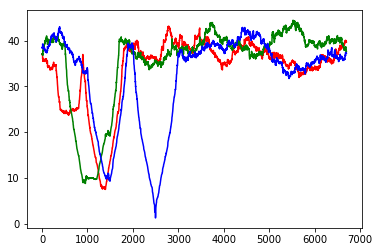

Calculation took 20.98789405822754 seconds


In [11]:
#Single thread version

ALT_single = [None]*3
start = time.time()

ALT_single[0] = getTScore(0)
ALT_single[1] = getTScore(1)
ALT_single[2] = getTScore(2)

#ALT_single[0] = getCI_upper(0)
#ALT_single[1] = getCI_upper(1)
#ALT_single[2] = getCI_upper(2)

plt.plot(ALT_single[0], color='red')
plt.plot(ALT_single[1], color='green')
plt.plot(ALT_single[2], color='blue')
plt.show()

process_time = time.time() - start
process_time
print("Calculation took {} seconds".format(process_time))

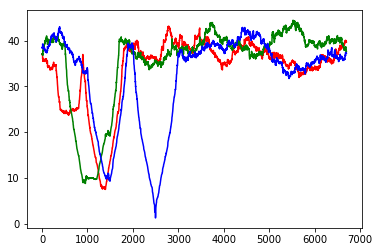

Multithreading took 38.15507507324219 seconds


In [12]:
#Multithreading

totalThreads=3
ALT_multi = [None]*3
    
def ParallelRegression_TS(threadnum):
    ALT_multi[threadnum] = getTScore(threadnum)
#    ALT_multi[threadnum] = getCI_upper(threadnum)    

threads=[]
start = time.time()
for threadnum in range(totalThreads):
    t = threading.Thread(target=ParallelRegression_TS,args=[threadnum])
    threads.append(t)
    t.start()
for threadnum in range(totalThreads):
    threads[threadnum].join()
    
plt.plot(ALT_multi[0], color='Red')
plt.plot(ALT_multi[1], color='Green')
plt.plot(ALT_multi[2], color='Blue')
plt.show()

process_time = time.time() - start
process_time
print("Multithreading took {} seconds".format(process_time))